#Multiple Linear Regression using RFE, Statsmodels and Mean Target Encoding
## Problem Statement
A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts. 
<br>
They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

- Which variables are significant in predicting the price of a car
- How well those variables describe the price of a car
<br>
Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the Americal market.

In [1]:
# Import necessary modules for data analysis and data visualization. 
import pandas as pd
import numpy as np

# Some visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

## Some other snippit of codes to get the setting right 
%matplotlib inline 
import warnings ## importing warnings library. 
warnings.filterwarnings('ignore') ## Ignore warning

## Understanding the data

In [2]:
#Loading the data
car = pd.read_csv("../input/CarPrice_Assignment.csv")
car.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
#checking basic details
car.shape

(205, 26)

In [4]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

 **As we can see, this dataset does not contain any missing value**

## Data Cleaning

In [5]:
#checking for duplicated rows
car[car.duplicated()]

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price


As we can see we dont have any duplicate record.

In [6]:
#removing car_ID column as it is insignificant 
car.drop('car_ID', axis=1, inplace=True)

In [7]:
#Extracting car company name from CarName column
car['CarName'] = car['CarName'].apply(lambda x: x.split()[0])

In [8]:
#checking the slpit and data quality issues
car['CarName'].value_counts().index.sort_values()

Index(['Nissan', 'alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge',
       'honda', 'isuzu', 'jaguar', 'maxda', 'mazda', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porcshce', 'porsche', 'renault',
       'saab', 'subaru', 'toyota', 'toyouta', 'vokswagen', 'volkswagen',
       'volvo', 'vw'],
      dtype='object')

- Here we can see various data quality issues 
  - mazda is written as `maxda`
  - nissan is written as `Nissan`
  - porsche is written as `porcshce`
  - toyota is written as `toyouta`
  - for volkswagen we have `vokswagen` and `vw`

**We will correct the names one by one**

In [9]:
#replacing car names with correct ones
car['CarName'] = car['CarName'].replace('maxda','mazda')
car['CarName'] = car['CarName'].replace('Nissan','nissan')
car['CarName'] = car['CarName'].replace('porcshce','porsche')
car['CarName'] = car['CarName'].replace('toyouta','toyota')
car['CarName'] = car['CarName'].replace('vokswagen','volkswagen')
car['CarName'] = car['CarName'].replace('vw','volkswagen')

In [10]:
#checking the car names again
car['CarName'].value_counts()

toyota         32
nissan         18
mazda          17
honda          13
mitsubishi     13
volkswagen     12
subaru         12
volvo          11
peugeot        11
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
porsche         5
isuzu           4
chevrolet       3
jaguar          3
alfa-romero     3
renault         2
mercury         1
Name: CarName, dtype: int64

Now we can see we have unique car names

In [11]:
#renaming Carname column to companyname
car = car.rename(columns={'CarName':'CompanyName'})

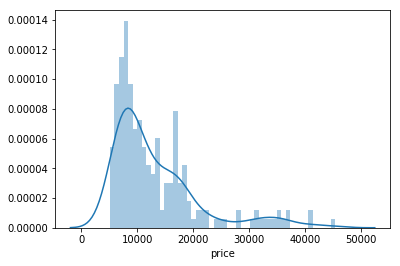

In [12]:
#checking distribution of price column
sns.distplot(car['price'], bins=50)
plt.show()

## Derived Metrics

symboling : Its assigned insurance risk rating, A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.(Categorical) 		


In [13]:
#creating symbol function and applying it of symboling column
def symbol(x):
    if x >= -3 & x <= -1:
        return 'No Risk'
    elif x>=0 and x <= 1:
        return 'Low Risk'
    else:
        return 'High Risk'
car['symboling'] = car['symboling'].apply(symbol)

In [14]:
car.symboling.value_counts()

Low Risk     121
High Risk     59
No Risk       25
Name: symboling, dtype: int64

In [15]:
#creating fuel economy metric
car['fueleconomy'] = (0.55 * car['citympg']) + (0.45 * car['highwaympg'])

In [16]:
#removing citympg and highwaympg cols as their effect is considered in fueleconomy
car.drop(['citympg','highwaympg'],axis=1, inplace=True)

In [17]:
car.head()

,symboling,CompanyName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,price,fueleconomy
0,High Risk,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,13495.0,23.70
1,High Risk,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,16500.0,23.70
2,Low Risk,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,16500.0,22.15
3,High Risk,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,13950.0,26.70
4,High Risk,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,17450.0,19.80


In [18]:
#recognising categorical and numerical features
cat_features = car.dtypes[car.dtypes == 'object'].index
print('No of categorical fetures:',len(cat_features),'\n')
print(cat_features)
print('*'*100)

num_features = car.dtypes[car.dtypes != 'object'].index
print('No of numerical fetures:',len(num_features),'\n')
print(num_features)

No of categorical fetures: 11 

Index(['symboling', 'CompanyName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'enginetype',
       'cylindernumber', 'fuelsystem'],
      dtype='object')
****************************************************************************************************
No of numerical fetures: 13 

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'price', 'fueleconomy'],
      dtype='object')


In [19]:
car[cat_features].head()

,symboling,CompanyName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,High Risk,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,High Risk,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,Low Risk,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,High Risk,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,High Risk,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [20]:
car[num_features].head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,price,fueleconomy
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,13495.0,23.70
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,16500.0,23.70
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,16500.0,22.15
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,13950.0,26.70
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,17450.0,19.80


In [21]:
#checking stats of numerical features
car[num_features].describe()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,price,fueleconomy
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,13276.710571,27.708780
std,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,7988.852332,6.649183
min,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,5118.000000,14.800000
25%,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,7788.000000,21.950000
50%,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,10295.000000,26.700000
75%,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,16503.000000,31.800000
max,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,45400.000000,51.250000


## EDA

### EDA on numerical variables

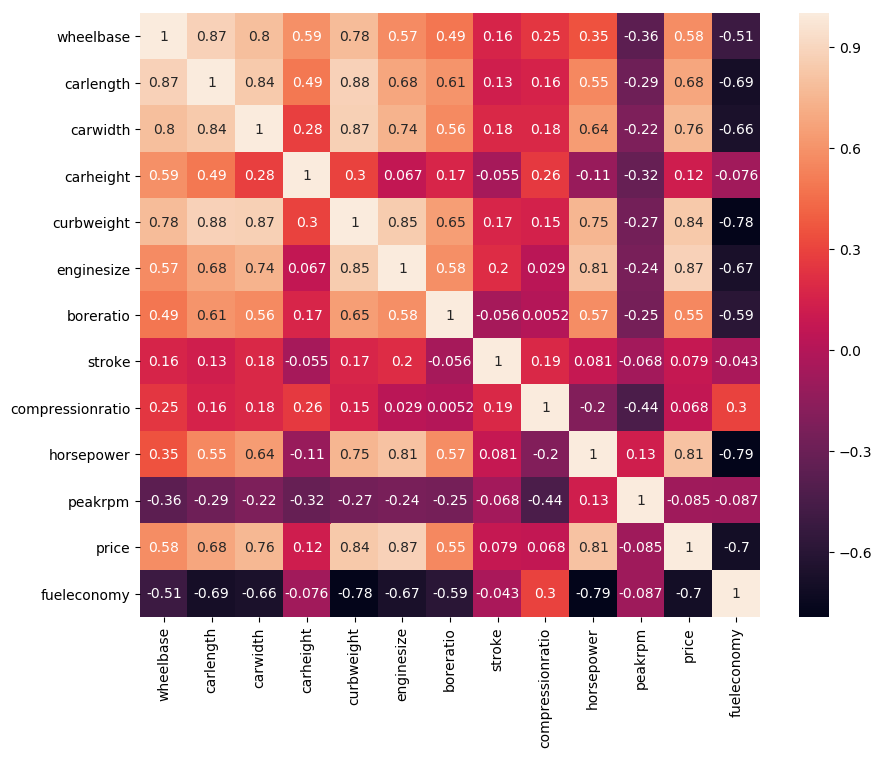

In [22]:
#checking correlation of all numerical variables
plt.figure(figsize=(10,8),dpi=100)
sns.heatmap(car[num_features].corr(), annot=True)
plt.show()

As we can see from the above heatmap, **wheelbase, carlength, carwidth, curbweight, enginesize & horsepower** are highly positivily correlated with `price`

**fuel economy** is highly negatively correlated

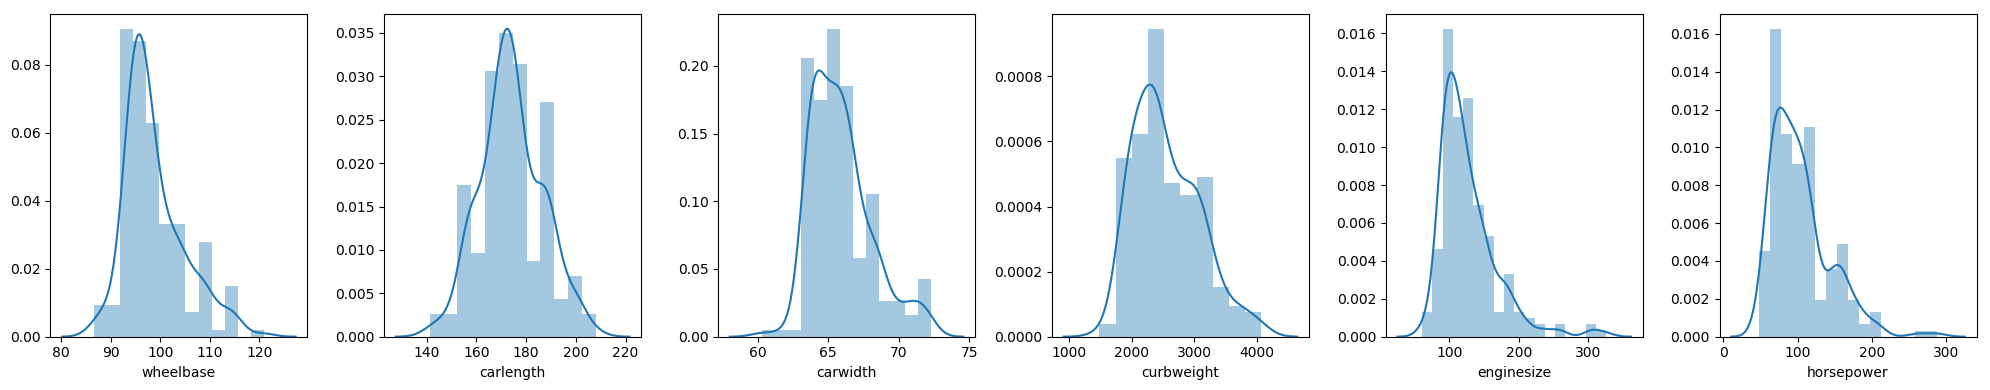

In [23]:
#checking the distribution of highly correlated numerical features with price variable
cols = ['wheelbase','carlength', 'carwidth', 'curbweight', 'enginesize','horsepower']
plt.figure(figsize=(20,4), dpi=100)
i = 1
for col in cols:
    plt.subplot(1,6,i)
    #sns.distplot(car['price'])
    sns.distplot(car[col])
    i = i+1
plt.tight_layout()
plt.show()

All these features follows nearly normal distribution

In [24]:
num_features

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'price', 'fueleconomy'],
      dtype='object')

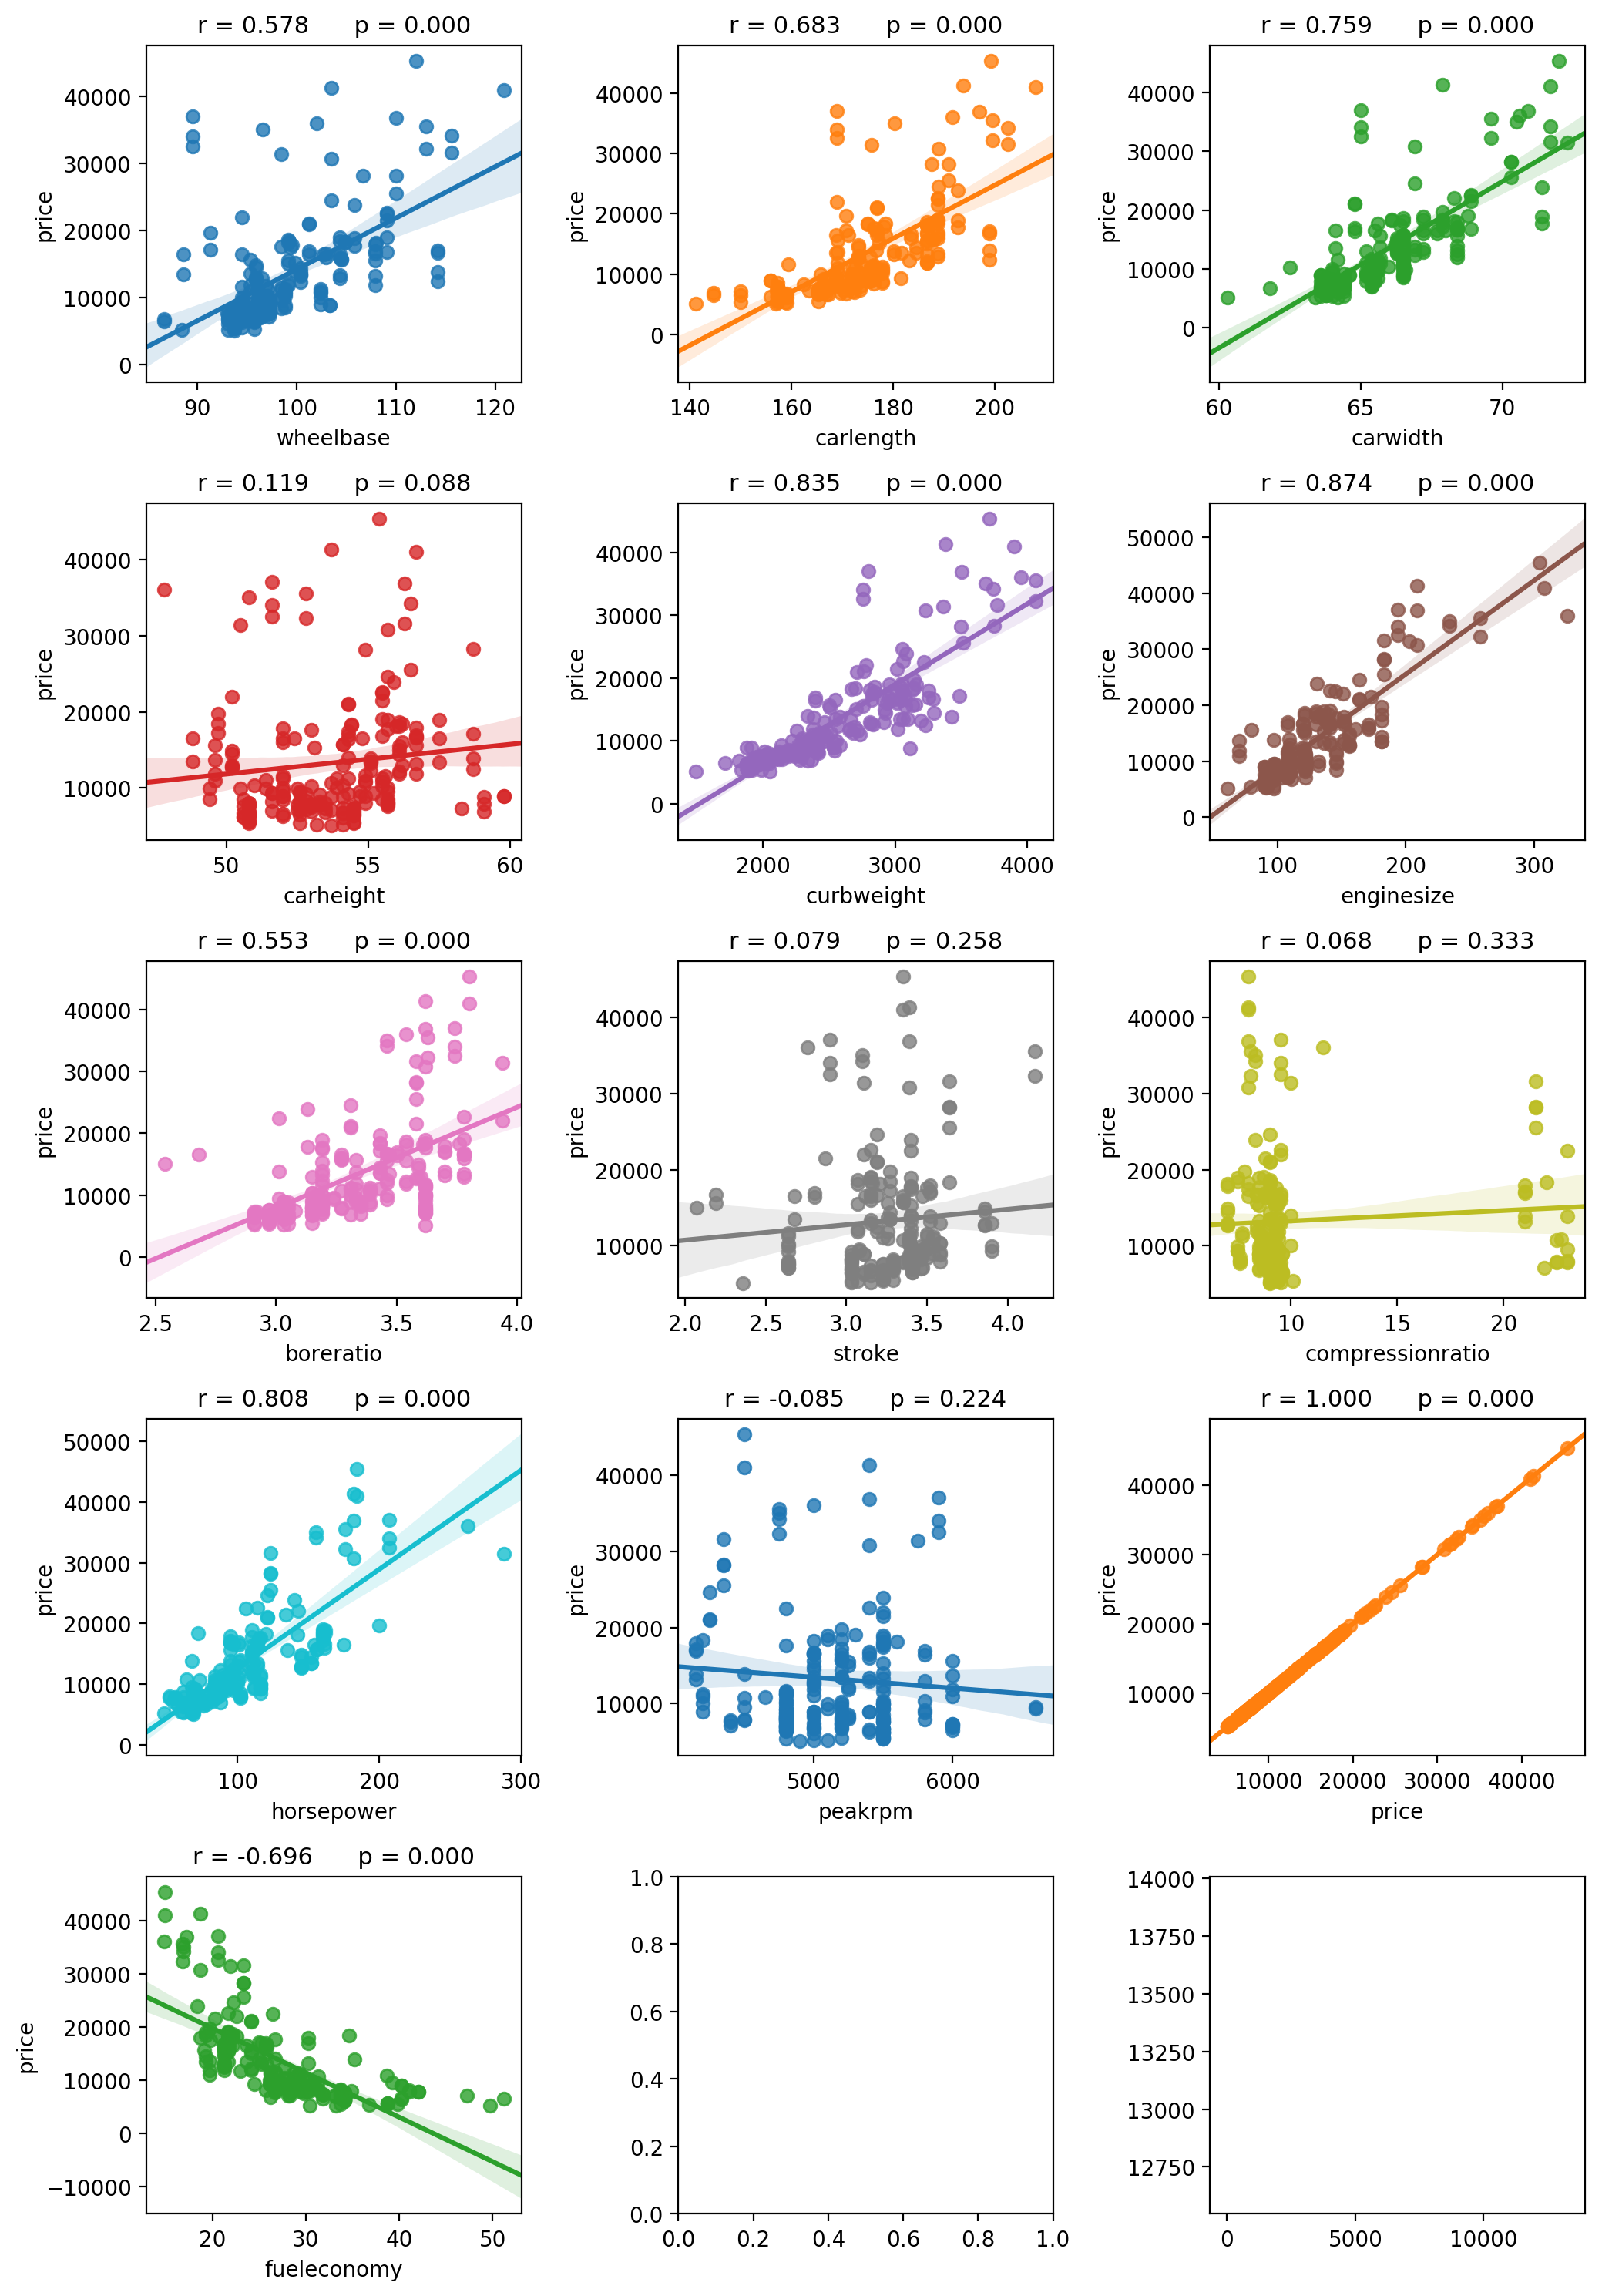

In [25]:
#visualising all the numerical features against price column

nr_rows = 5
nr_cols = 3
from scipy import stats
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3),dpi=200)

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(num_features):
            sns.regplot(car[num_features[i]], car['price'], ax = axs[r][c])
            stp = stats.pearsonr(car[num_features[i]], car['price'])
            str_title = "r = " + "{0:.3f}".format(stp[0]) + "      " "p = " + "{0:.3f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

From the above graph, we can make the following inferences:
- **stroke, compressionratio and peakrpm** have very low correlation with price variable
- All these variables have high p value (> 0.05), we can say that they will be insignificant in our model building process, so we will remove them

In [26]:
#removing these columns
car.drop(['carheight','stroke','compressionratio','peakrpm'],axis=1, inplace=True)

### EDA on Categorical Variables

In [27]:
#checking unique value counts of categorical features
car[cat_features].nunique().sort_values()

fueltype           2
aspiration         2
doornumber         2
enginelocation     2
symboling          3
drivewheel         3
carbody            5
enginetype         7
cylindernumber     7
fuelsystem         8
CompanyName       22
dtype: int64

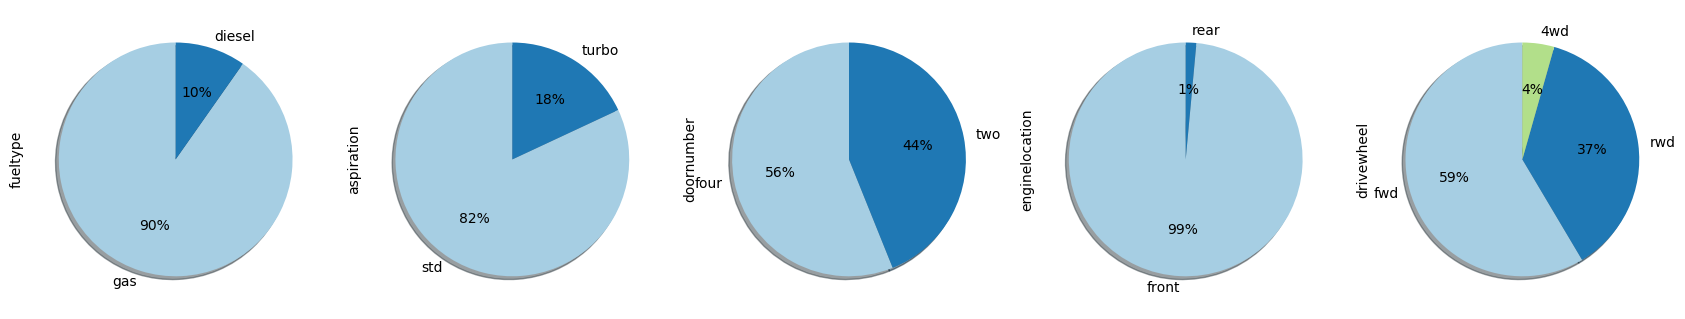

In [28]:
#eda on categorical columns
cols = ['fueltype','aspiration', 'doornumber','enginelocation','drivewheel']
i = 1
plt.figure(figsize=(17,8),dpi=100)
for col in cols:
    plt.subplot(1,len(cols),i)
    car[col].value_counts().plot.pie(autopct='%1.0f%%', startangle=90, shadow = True,colors = sns.color_palette('Paired'))
    i = i+1
plt.tight_layout()
plt.show()

We can easily draw following points :
 - Most number of cars runs on gasoline in America
 - Standard aspiration is preferred over turbo aspiration
 - There is only 1% cars which are having engine at rear position
 - People prefer front wheel derive cars

In [29]:
#dropping engine location as it is highly imbalanced
car.drop('enginelocation',axis=1,inplace=True)

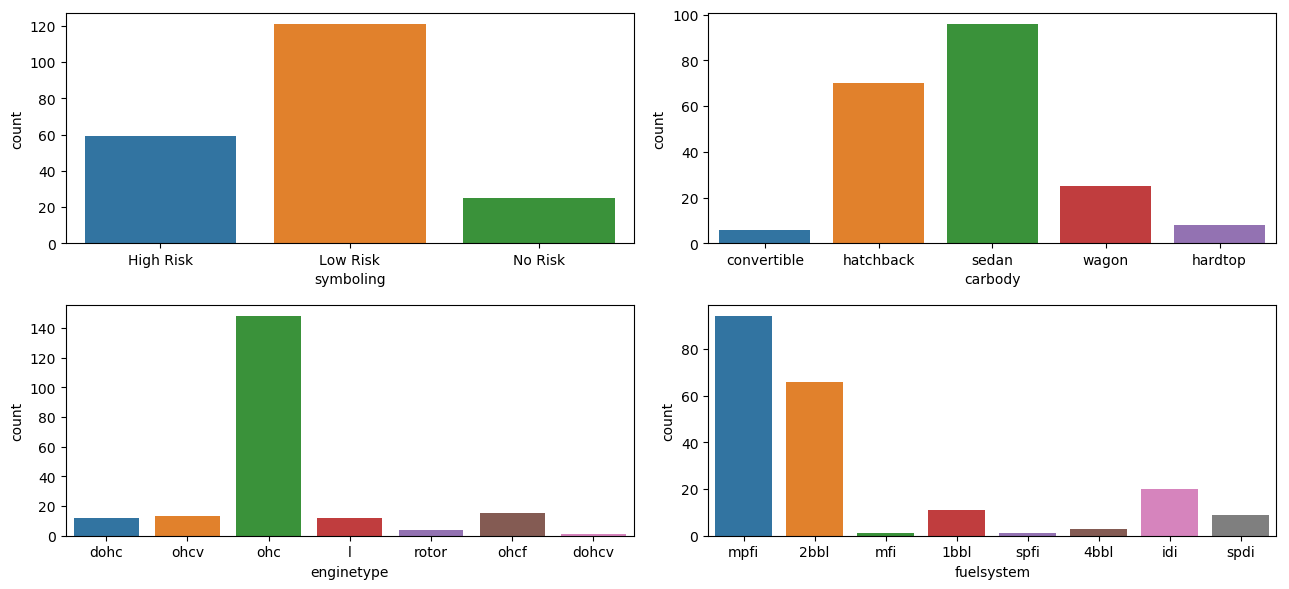

In [30]:
#making countplot for all below categorical variables
cols = ['symboling','carbody', 'enginetype', 'fuelsystem']
nr_rows = 2
nr_cols = 2
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6.5,nr_rows*3),dpi=100)

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(cols):
            sns.countplot(car[cols[i]], ax = axs[r][c])
            
plt.tight_layout()    
plt.show()   

Some useful points:
 - Cars with Low risk rating are more in number
 - people prefer Sedan and Hatchback cars
 - 4 cylinder OHC(Over head cam) type engine is more poplular in America

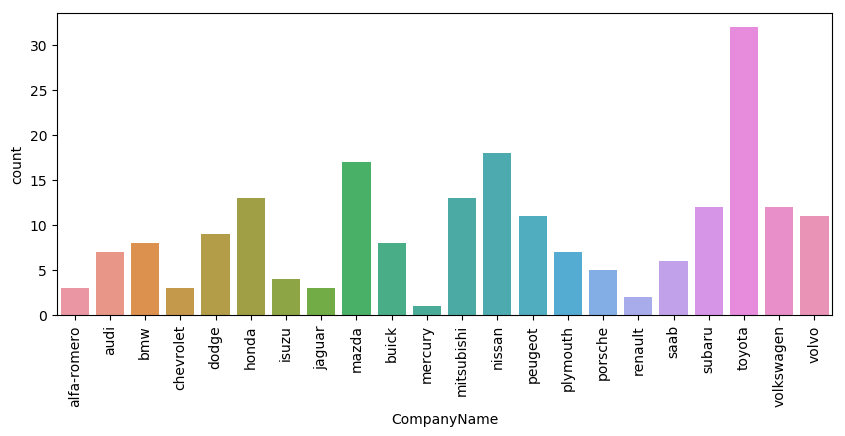

In [31]:
#visualising carname feature
plt.figure(figsize=(10,4),dpi=100)
sns.countplot(car['CompanyName'])
plt.xticks(rotation=90)
plt.show()

Lets visaualize effect of categorical variables on price

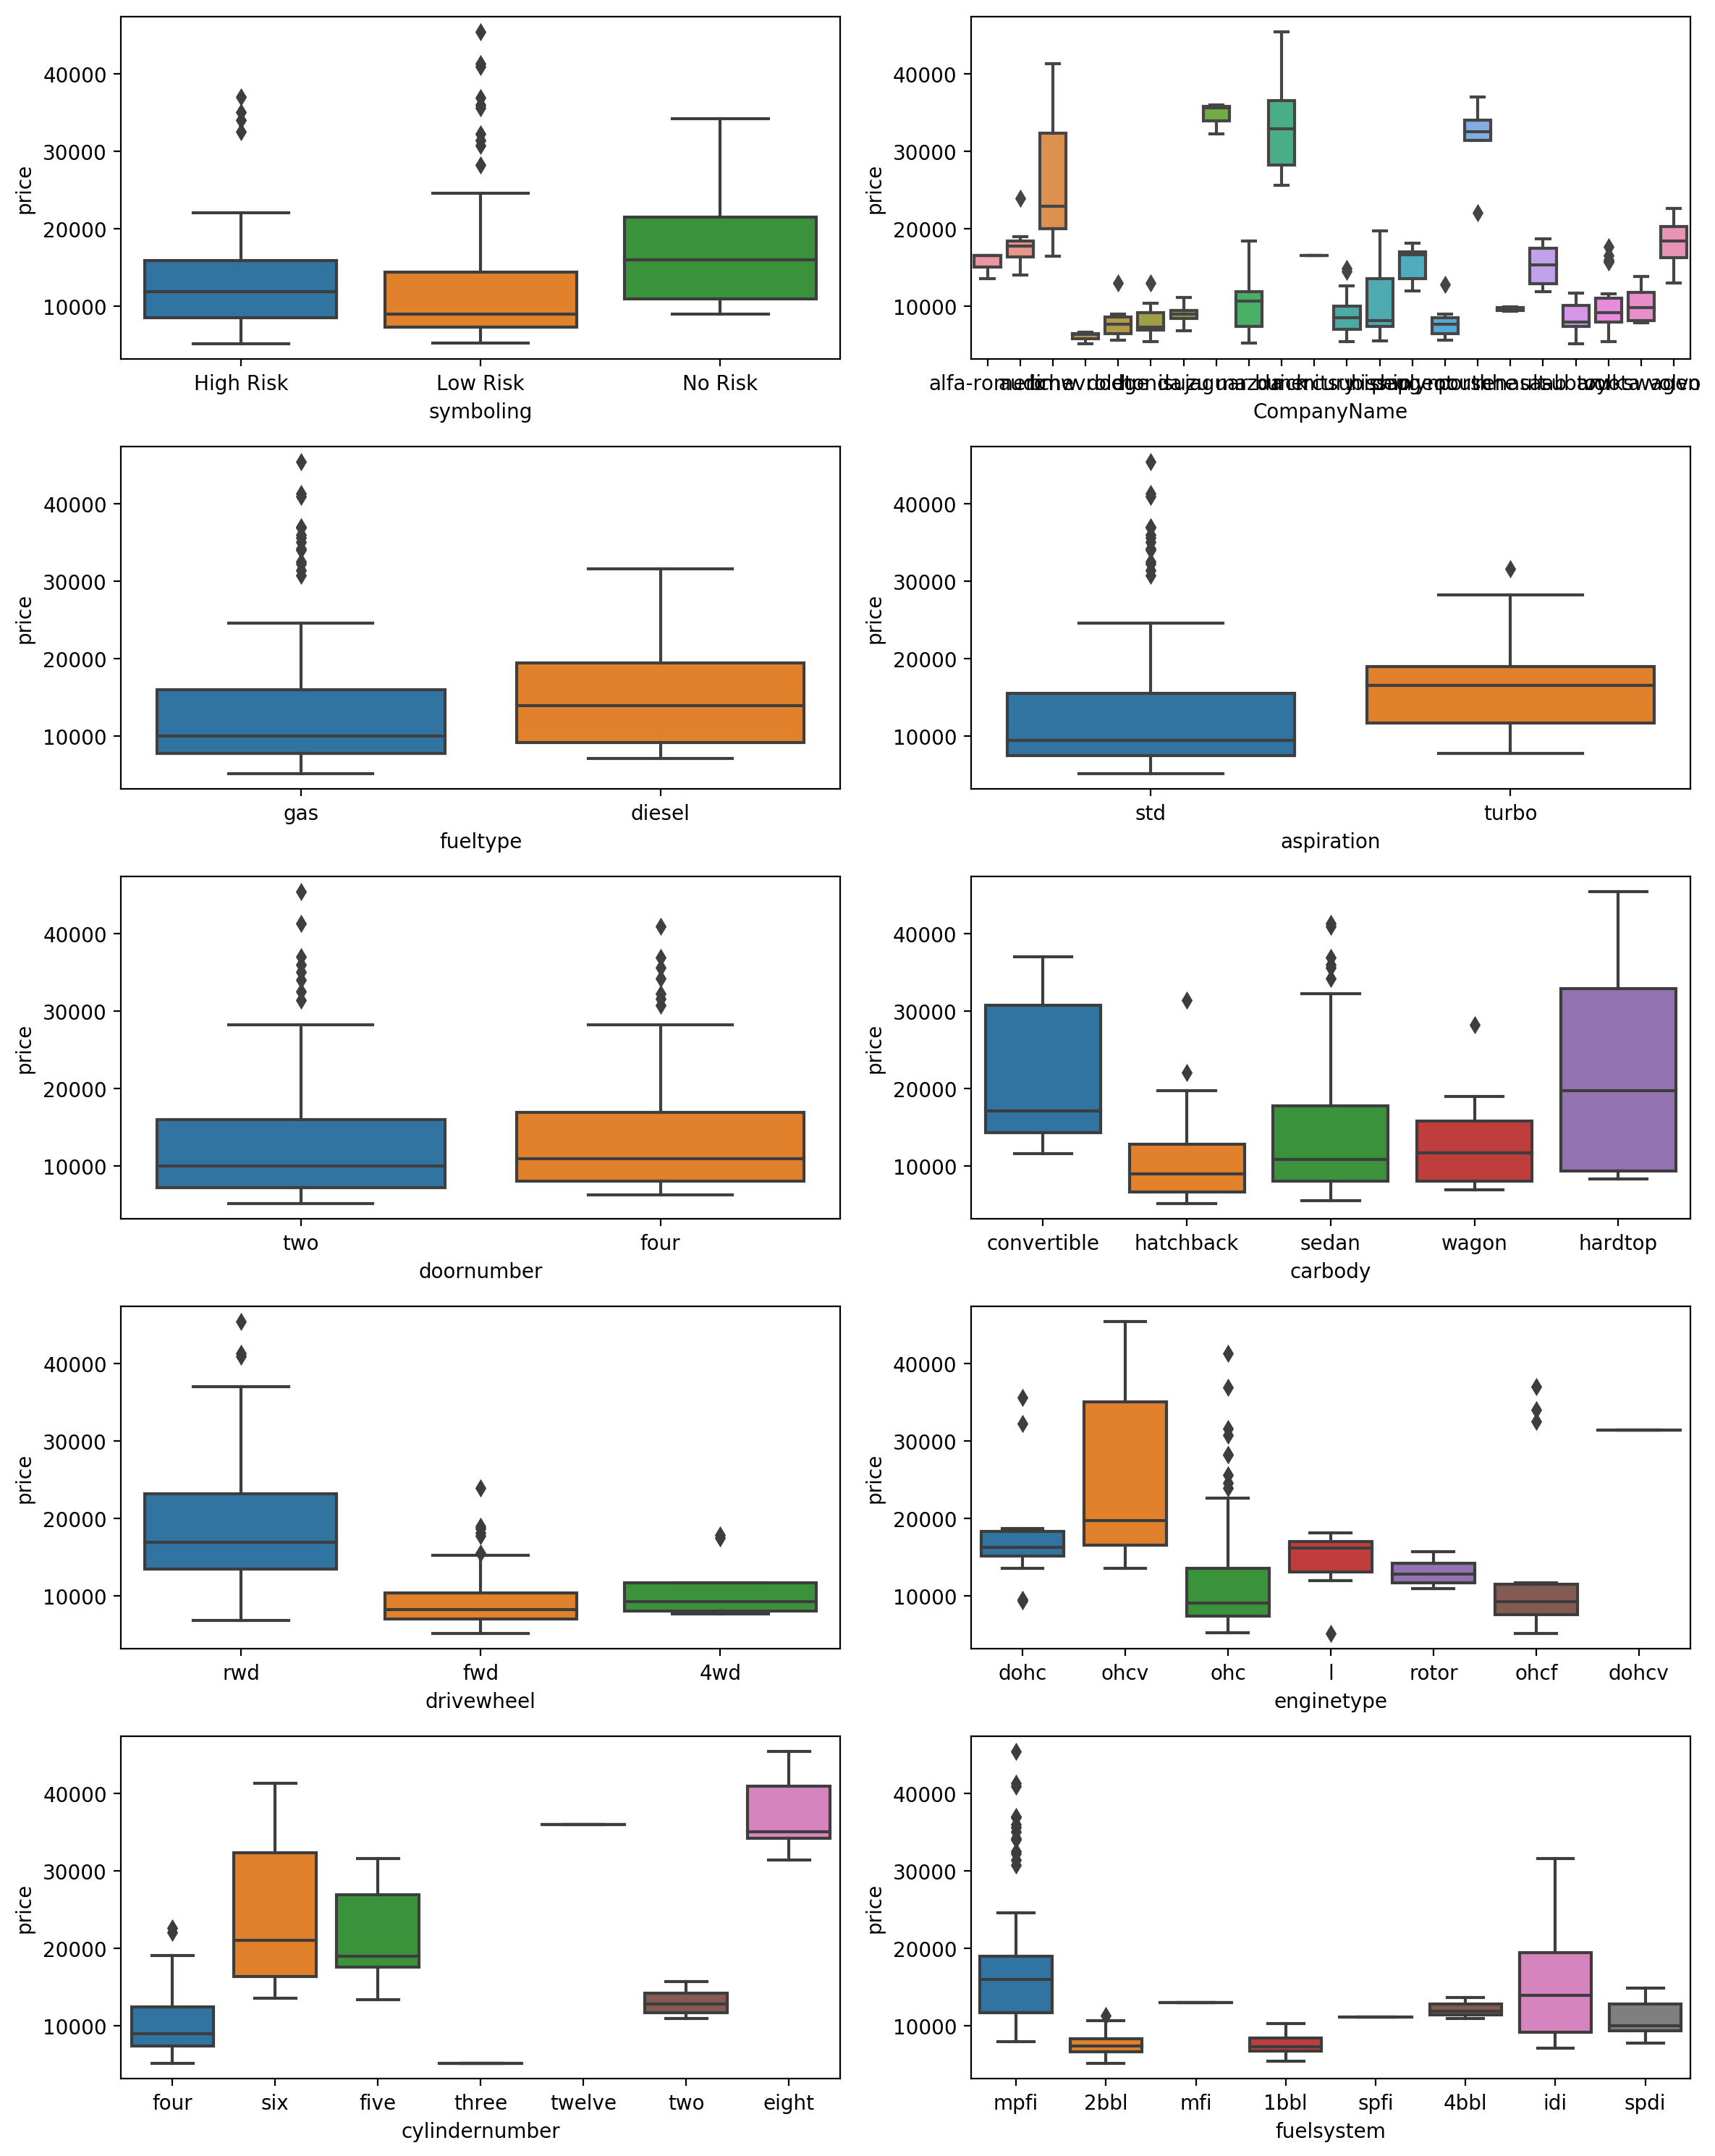

In [32]:
li_cat_feats = list(car.dtypes[car.dtypes=='object'].index)
nr_rows = 5
nr_cols = 2
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_rows*3),dpi=200)
for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y='price', data=car, ax = axs[r][c])
plt.tight_layout()    
plt.show() 

We can draw following points from the above graphs:
 - Price of car does not depend much on Doornumber of car
 - Price of car does depend on number brand name in the car <br>
Except doornumber , price of car depends on every other feature

In [33]:
#removing doornumber from the dataset
car.drop('doornumber',axis=1, inplace=True)

## Data Preprocessing

### Encoding of categorical variables

We will use one-hot code encoding for this assignment.

In [34]:
cat_features = car.dtypes[car.dtypes == 'object'].index

In [35]:
car[cat_features].nunique().sort_values()

fueltype           2
aspiration         2
symboling          3
drivewheel         3
carbody            5
enginetype         7
cylindernumber     7
fuelsystem         8
CompanyName       22
dtype: int64

In [36]:
#creating function for targe encoding
#credits : https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [37]:
#performing target encoding with weight of 100
for col in cat_features:
    car[col] = calc_smooth_mean(car,by=col, on='price', m=100)

### Train-Test split

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
df_train, df_test = train_test_split(car, test_size=0.3, random_state=42)
print(df_train.shape)
print(df_test.shape)

(143, 18)
(62, 18)


### Feature scaling

Here we will scale full dataframe using MinMax scaler

In [40]:
cols = df_train.columns

In [41]:
#importing minmax scaler from sklearn.preprocessing and scaling the training dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[cols] = scaler.fit_transform(df_train[cols])

In [42]:
#transforming the test data set
df_test[cols] = scaler.transform(df_test[cols])

In [43]:
#checking minmax scaling
df_train.describe()

,symboling,CompanyName,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,price,fueleconomy
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.240427,0.283915,0.083916,0.188811,0.577481,0.398565,0.425175,0.518194,0.398934,0.335664,0.178150,0.175167,0.222711,0.599154,0.557542,0.227539,0.205812,0.458523
std,0.338584,0.243336,0.278236,0.392734,0.423024,0.482655,0.209439,0.213919,0.207804,0.232474,0.307781,0.357541,0.161861,0.438927,0.194528,0.170949,0.194490,0.220142
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.134995,0.000000,0.000000,0.000000,0.000000,0.272414,0.382759,0.228571,0.165332,0.000000,0.000000,0.109375,0.000000,0.435714,0.095339,0.068976,0.269725
50%,0.000000,0.189106,0.000000,0.000000,0.925245,0.000000,0.365517,0.496552,0.352381,0.277704,0.000000,0.000000,0.195312,0.610562,0.550000,0.182203,0.140931,0.436697
75%,0.399538,0.446720,0.000000,0.000000,0.925245,1.000000,0.537931,0.689655,0.485714,0.504673,0.452987,0.000000,0.277344,1.000000,0.714286,0.271186,0.284358,0.615596
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


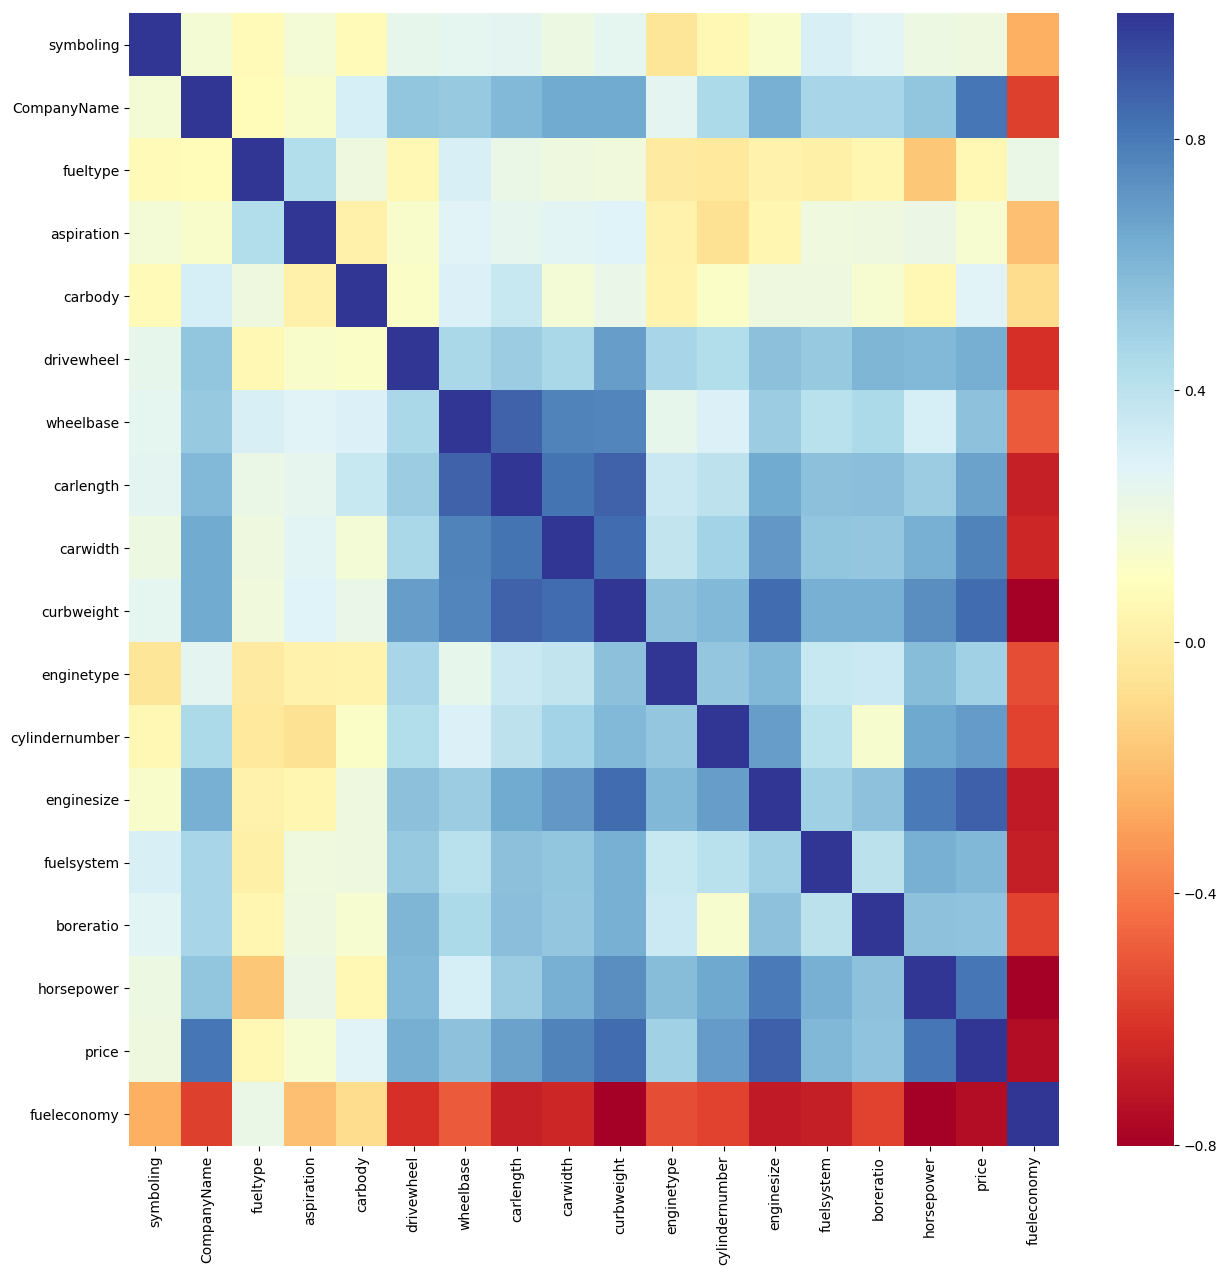

In [44]:
#checking correlation of train dataframe 
plt.figure(figsize=(15,15),dpi=100)
sns.heatmap(df_train.corr(), cmap='RdYlBu')
plt.show()

In [45]:
#creating function for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

## Model building

In [46]:
#creating X and y variables
y_train = df_train.pop('price')
X_train = df_train

In [47]:
print(X_train.shape)

(143, 17)


In [48]:
#feature selection using RFE
#In this case we are have 57 features , lets select 20 features from the data using RFE and then we will 
# remove statistical insignificant variables one by one
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)

rfe = RFE(lr,10)
rfe.fit(X_train,y_train)

print(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
print('*'*100)
cols_rfe = X_train.columns[rfe.support_]
print('Features with RFE support:')
print(cols_rfe)
print('*'*100)
print('Features without RFE support:')
cols_not_rfe = X_train.columns[~rfe.support_]
print(cols_not_rfe)

[('symboling', False, 7), ('CompanyName', True, 1), ('fueltype', False, 3), ('aspiration', False, 6), ('carbody', True, 1), ('drivewheel', False, 5), ('wheelbase', True, 1), ('carlength', True, 1), ('carwidth', True, 1), ('curbweight', True, 1), ('enginetype', True, 1), ('cylindernumber', True, 1), ('enginesize', True, 1), ('fuelsystem', False, 8), ('boreratio', False, 4), ('horsepower', True, 1), ('fueleconomy', False, 2)]
****************************************************************************************************
Features with RFE support:
Index(['CompanyName', 'carbody', 'wheelbase', 'carlength', 'carwidth',
       'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'horsepower'],
      dtype='object')
****************************************************************************************************
Features without RFE support:
Index(['symboling', 'fueltype', 'aspiration', 'drivewheel', 'fuelsystem',
       'boreratio', 'fueleconomy'],
      dtype='object')

In [49]:
#taking cols with RFE support
X_train = X_train[cols_rfe]

In [50]:
#checking VIF
vif(X_train).head(10)

,Features,VIF
3,carlength,45.47
2,wheelbase,29.97
5,curbweight,26.24
4,carwidth,22.75
8,enginesize,15.25
9,horsepower,10.18
0,CompanyName,5.01
1,carbody,3.87
7,cylindernumber,2.56
6,enginetype,2.50


In [51]:
#removing carlength as it is having VIF
X_train.drop('carlength', axis=1, inplace=True)
vif(X_train).head()

,Features,VIF
4,curbweight,24.59
3,carwidth,21.00
2,wheelbase,18.86
7,enginesize,15.19
8,horsepower,9.48


In [52]:
#removing curbweight as it is having high VIF
X_train.drop('curbweight', axis=1, inplace=True)
vif(X_train).head()

,Features,VIF
3,carwidth,20.78
2,wheelbase,14.25
6,enginesize,13.17
7,horsepower,9.08
0,CompanyName,4.88


In [53]:
#removing carwidth as it is having high VIF
X_train.drop('carwidth', axis=1, inplace=True)
vif(X_train).head()

,Features,VIF
5,enginesize,12.92
6,horsepower,7.86
2,wheelbase,5.90
0,CompanyName,4.70
1,carbody,2.96


In [54]:
#removing enginesize as it is having high VIF
X_train.drop('enginesize', axis=1, inplace=True)
vif(X_train).head()

,Features,VIF
5,horsepower,5.39
2,wheelbase,5.09
0,CompanyName,4.50
1,carbody,2.93
4,cylindernumber,2.26


Lets start building model and we will remove other statistically insignificant variables based on p-value and vif

In [55]:
#importing statsmodel
import statsmodels.api as sm

In [56]:
#Building the first model
X_train_lr = sm.add_constant(X_train)
lr_1 = sm.OLS(y_train,X_train_lr).fit()
print(lr_1.summary())
print(vif(X_train))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     194.5
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           3.60e-64
Time:                        11:59:17   Log-Likelihood:                 193.30
No. Observations:                 143   AIC:                            -372.6
Df Residuals:                     136   BIC:                            -351.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0801      0.014     -5.

In [57]:
#removing enginetype as it is having p-value  and building 2nd model
X_train.drop('enginetype', axis=1, inplace=True)
X_train_lr = sm.add_constant(X_train)
lr_2 = sm.OLS(y_train,X_train_lr).fit()
print(lr_2.summary())
print(vif(X_train))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     234.5
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           2.57e-65
Time:                        11:59:17   Log-Likelihood:                 193.15
No. Observations:                 143   AIC:                            -374.3
Df Residuals:                     137   BIC:                            -356.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0807      0.014     -5.

In [58]:
#removing wheelbase as it is having high VIF building 3rd model
X_train.drop('wheelbase', axis=1, inplace=True)
X_train_lr = sm.add_constant(X_train)
lr_3 = sm.OLS(y_train,X_train_lr).fit()
print(lr_3.summary())
print(vif(X_train))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     263.6
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           1.49e-63
Time:                        11:59:17   Log-Likelihood:                 185.92
No. Observations:                 143   AIC:                            -361.8
Df Residuals:                     138   BIC:                            -347.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0501      0.012     -4.

Now we can see our model have all the variables having VIF less than 5 and all the p-values less than 0.05, so we can say that our model is good.

## Residual Analysis

In [59]:
#calculating residuals
y_train_pred = lr_3.predict(X_train_lr)
residuals = y_train-y_train_pred

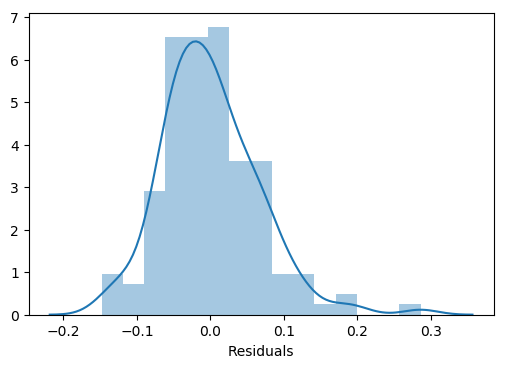

In [60]:
#plotting residuals
plt.figure(dpi=100)
sns.distplot(residuals)
plt.xlabel('Residuals')
plt.show()

In [61]:
#checking mean of residuals
np.mean(residuals)

-9.850317919532638e-17

As we can see , residuals are normally distributed and have a mean of zero

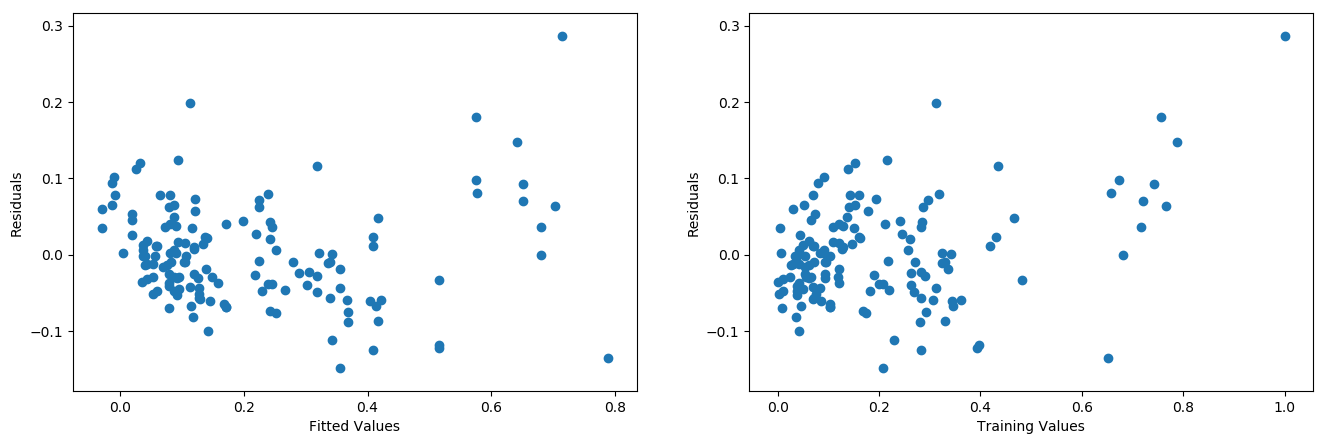

In [62]:
#scatterplot of resuduals v/s fitted values
plt.figure(figsize=(16,5),dpi=100)
plt.subplot(121)
plt.scatter(y_train_pred,residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.subplot(122)
plt.scatter(y_train,residuals)
plt.xlabel('Training Values')
plt.ylabel('Residuals')
plt.show()

We are not having any pattern of residuals with either fitted value or training values 

Text(0, 0.5, 'Residuals')

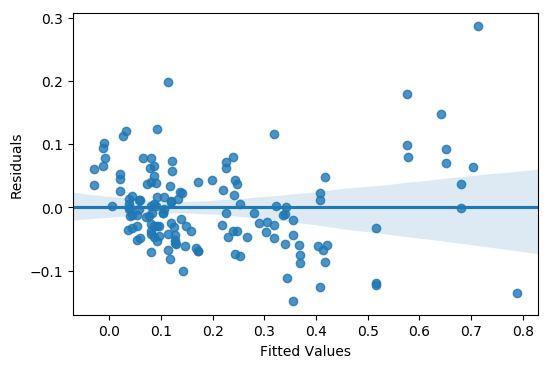

In [63]:
plt.figure(dpi=100)
sns.regplot(y_train_pred,residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

As we can see from the above graphs residuals does not have any pattern with fitted and training values, so we can say that our model is good.

## Making predictions

In [64]:
#checking the test data
df_test.describe()

,symboling,CompanyName,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,price,fueleconomy
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,0.228898,0.262679,0.129032,0.161290,0.537586,0.364448,0.405395,0.483648,0.373425,0.309660,0.163377,0.215078,0.221333,0.509846,0.579263,0.205372,0.194994,0.508760
std,0.329553,0.269942,0.337972,0.370801,0.435062,0.468721,0.204468,0.209627,0.196487,0.230834,0.294020,0.368156,0.165835,0.436438,0.191679,0.159743,0.208323,0.290709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.060345,-0.142857,-0.147308,0.000000,0.000000,-0.035156,0.000000,0.264286,-0.016949,0.000819,0.003670
25%,0.000000,0.134995,0.000000,0.000000,0.000000,0.000000,0.272414,0.374138,0.190476,0.136182,0.000000,0.000000,0.105469,0.000000,0.435714,0.072034,0.066041,0.254128
50%,0.000000,0.165429,0.000000,0.000000,0.726094,0.000000,0.350000,0.475862,0.347619,0.256342,0.000000,0.000000,0.175781,0.562519,0.564286,0.177966,0.111117,0.491743
75%,0.399538,0.275993,0.000000,0.000000,0.925245,1.000000,0.527586,0.577586,0.447619,0.477637,0.423477,0.470005,0.296875,1.000000,0.767857,0.283898,0.246804,0.693578
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.182759,1.094828,0.942857,0.926124,1.000000,1.000000,0.929688,1.000000,0.900000,0.656780,0.898590,1.337615


In [65]:
#creating X and y for test dataframe
y_test = df_test.pop('price')
X_test = df_test
X_test.head()

,symboling,CompanyName,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,fueleconomy
15,0.000000,0.760763,0.0,0.0,0.925245,1.00000,0.582759,0.765517,0.485714,0.627948,0.0,1.000000,0.542969,1.000000,0.771429,0.550847,0.143119
9,0.000000,0.481274,0.0,1.0,0.000000,0.39895,0.444828,0.579310,0.580952,0.549177,0.0,0.692288,0.238281,1.000000,0.421429,0.457627,0.143119
100,0.000000,0.165429,0.0,0.0,0.925245,0.00000,0.365517,0.496552,0.323810,0.214953,0.0,0.000000,0.195312,0.000000,0.564286,0.190678,0.563303
132,0.399538,0.399933,0.0,0.0,0.000000,0.00000,0.431034,0.724138,0.447619,0.373387,0.0,0.000000,0.199219,1.000000,0.714286,0.245763,0.343119
68,1.000000,1.000000,1.0,1.0,0.545972,1.00000,0.806897,0.798276,0.809524,0.859368,0.0,0.692288,0.441406,0.610562,0.742857,0.300847,0.313761


In [66]:
X_train.columns

Index(['CompanyName', 'carbody', 'cylindernumber', 'horsepower'], dtype='object')

In [67]:
#predicting test values
X_test = X_test[X_train.columns]
X_test = sm.add_constant(X_test)
y_test_pred = lr_3.predict(X_test)

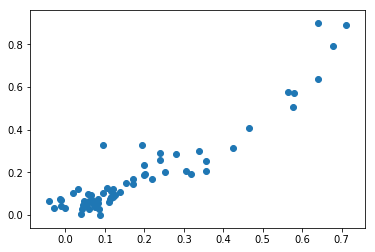

In [68]:
#scatterplot of y_test and y_test_pred
plt.scatter(y_test_pred,y_test)

We can see that we have almost linear relationship, so we can say that our model is good.

## Model Evaluation

In [69]:
#importing necessary libraries and methods
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#calculating r2_score 
r2_score(y_test,y_test_pred)

0.8675770124090468

As we can see r2-score of test set is `0.865` against r2-score of `0.884` and adjusted-r2 score of `0.881` of training data set

In [70]:
#calculating mean squared error for test set
mean_squared_error(y_test,y_test_pred)

0.005654271496155228

In [71]:
#calculating mean squared error for traning set
mean_squared_error(y_train,y_train_pred)

0.0043473612324915634

Thank You for visiting the kernel : )